<center><h1>Haidar_Anastasia_HW5</h1></center>
<br>
<br>

Name: Anastasia Haidar
<br>
Github Username: haidarnastya
<br>
USC ID: 1163-9833-46

## 1. Decision Trees as Interpretable Models

Import packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import _tree
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

### (a) Obtain Data

Get the Accute Inamations Data Set

In [26]:
#import data 
#column names based on .names info
columns = ['temperature', 'nausea', 'lumbar_pain', 'urine_pushing', 'micturition_pains', 'burning_urethra', 'inflammation_bladder', 'nephritis_renal_pelvis']

#read .data
diagnosis_data = pd.read_csv('./data/diagnosis.data', encoding='utf-16', sep='\t', header=None, names=columns)

#convert temp column to numeric
diagnosis_data['temperature'] = diagnosis_data['temperature'].str.replace(',', '.').astype(float)

#convert yes/no columns to binary
yn_cols = columns[1:]
for col in yn_cols:
    diagnosis_data[col] = diagnosis_data[col].map({'yes':1, 'no': 0})

print(diagnosis_data.head())



   temperature  nausea  lumbar_pain  urine_pushing  micturition_pains  \
0         35.5       0            1              0                  0   
1         35.9       0            0              1                  1   
2         35.9       0            1              0                  0   
3         36.0       0            0              1                  1   
4         36.0       0            1              0                  0   

   burning_urethra  inflammation_bladder  nephritis_renal_pelvis  
0                0                     0                       0  
1                1                     1                       0  
2                0                     0                       0  
3                1                     1                       0  
4                0                     0                       0  


### (b) Build a decision tree

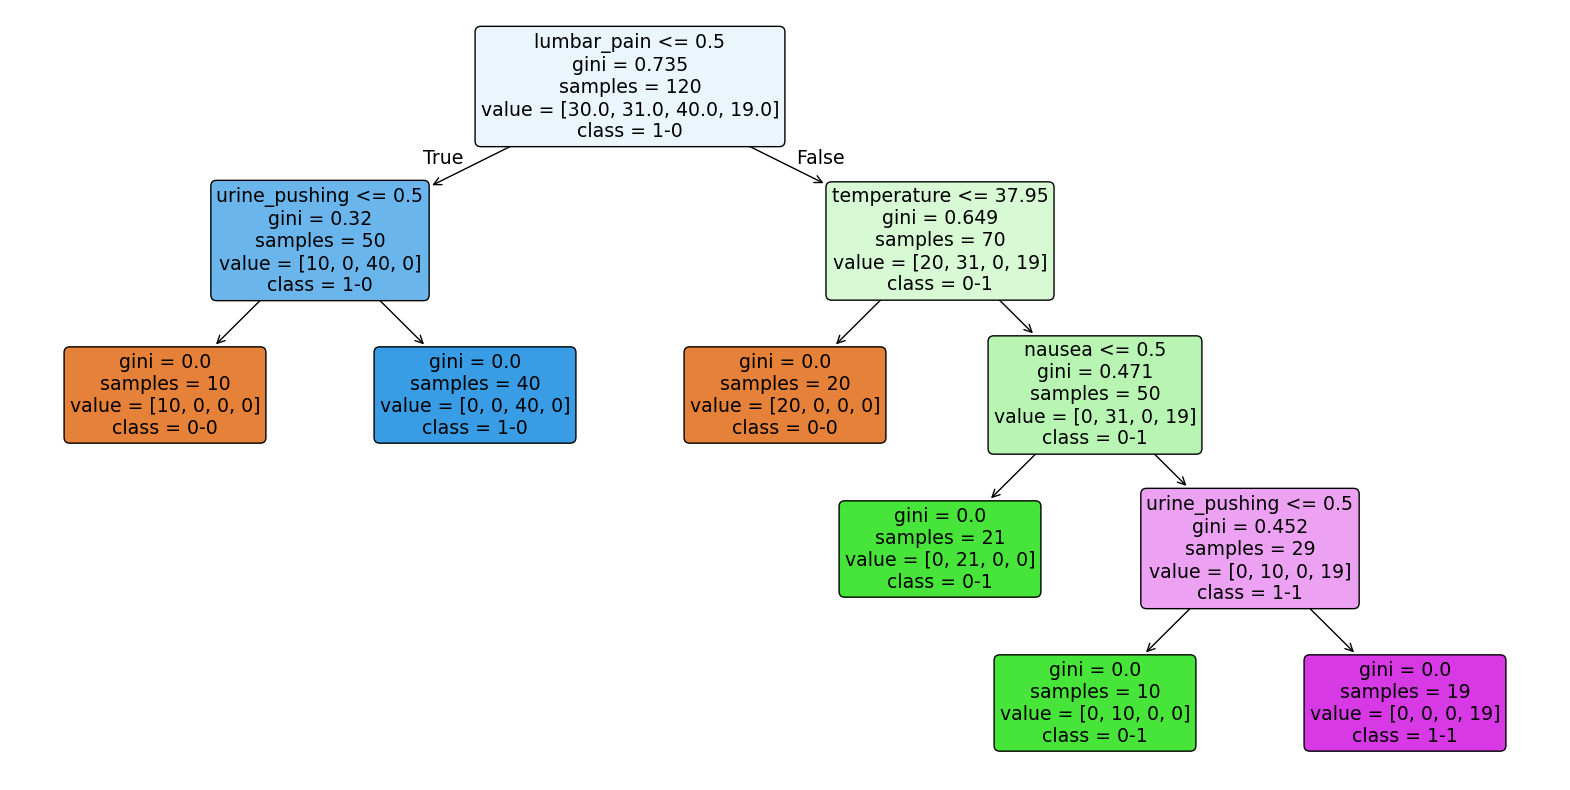

In [27]:
#identify features(x) and target(y)
x = diagnosis_data.iloc[:, :6]
y = diagnosis_data.iloc[:, 6:]

#use label powerset method
y_multilabel = y.astype(str).agg('-'.join, axis=1)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_multilabel)

#train decision tree on full data set
full_dt_model = DecisionTreeClassifier(random_state=42)
full_dt_model.fit(x, y_multilabel)

#plot the full tree
plt.figure(figsize=(20,10))
plot_tree(full_dt_model, feature_names=x.columns, class_names=encoder.classes_, filled=True, rounded=True)
plt.show()


### (c) Convert the decision rules

In [4]:
#represent model as IF-THEN function
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = " " * depth
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth +1)
            print("{}else: # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))
    recurse(0,1)

tree_to_code(full_dt_model, list(x.columns))

def tree(temperature, nausea, lumbar_pain, urine_pushing, micturition_pains, burning_urethra):
 if lumbar_pain <= 0.5:
  if urine_pushing <= 0.5:
   return [[1. 0. 0. 0.]]
  else: # if urine_pushing > 0.5
   return [[0. 0. 1. 0.]]
 else: # if lumbar_pain > 0.5
  if temperature <= 37.95000076293945:
   return [[1. 0. 0. 0.]]
  else: # if temperature > 37.95000076293945
   if nausea <= 0.5:
    return [[0. 1. 0. 0.]]
   else: # if nausea > 0.5
    if urine_pushing <= 0.5:
     return [[0. 1. 0. 0.]]
    else: # if urine_pushing > 0.5
     return [[0. 0. 0. 1.]]


In [5]:
#Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.
prune_path = full_dt_model.cost_complexity_pruning_path(x, y_multilabel)
ccp_alphas, impurities = prune_path.ccp_alphas, prune_path.impurities

models = []
for ccp_alpha in ccp_alphas:
    min_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    min_dt.fit(x, y_multilabel)
    models.append(min_dt)

#find "optimal" dt based on highest interpretability
training_scores = [m.score(x,y_multilabel) for m in models]
optimal_dt = ccp_alphas[training_scores.index(max(training_scores))]
pruned_dt_model = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_dt)
pruned_dt_model.fit(x, y_multilabel)


DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=42)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [6]:
#load data
data_path = './data/communities.data'

#column names in order from the .names file
column_names = [
    "state", "county", "community", "communityname", "fold",
    "population", "householdsize", "racepctblack", "racePctWhite",
    "racePctAsian", "racePctHisp", "agePct12t21", "agePct12t29",
    "agePct16t24", "agePct65up", "numbUrban", "pctUrban", "medIncome",
    "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec", "pctWPubAsst",
    "pctWRetire", "medFamInc", "perCapInc", "whitePerCap", "blackPerCap",
    "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap", "NumUnderPov",
    "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore",
    "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ",
    "PctOccupManu", "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr",
    "FemalePctDiv", "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5",
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous",
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos",
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart",
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ",
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg",
    "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT",
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop",
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop",
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp",
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits", "NumKindsDrugsSeiz",
    "PolicAveOTWorked", "LandArea", "PopDens", "PctUsePubTrans", "PolicCars",
    "PolicOperBudg", "LemasPctPolicOnPatr", "LemasGangUnitDeploy",
    "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"
]

#read the .data file

communities_data = pd.read_csv(data_path, header=None, names=column_names, na_values='?')
print(communities_data.shape)
print(communities_data.head())


(1994, 128)
   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20 

### (b) Missing values

In [7]:
#The data set has missing values. Use a data imputation technique to deal with
#the missing values in the data set. The data description mentions some features
#are nonpredictive. Ignore those features.
non_predictive = ['state', 'country', 'community', 'communityname', 'fold']

communities_data = communities_data.drop(columns=non_predictive, errors='ignore')

missing_values = communities_data.isna().sum()
print(missing_values[missing_values > 0].sort_values(ascending=False).head(20))

#impute using median values of each column
imputation = SimpleImputer(strategy='median')
communities_data[:] = imputation.fit_transform(communities_data)


LemasSwFTPerPop         1675
LemasSwornFT            1675
LemasSwFTFieldPerPop    1675
LemasSwFTFieldOps       1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicPerPop             1675
PolicReqPerOffic        1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
PolicAveOTWorked        1675
PolicCars               1675
dtype: int64


### (c) Plot a correlation matrix

                       county  population  householdsize  racepctblack  \
county               1.000000    0.077610      -0.023039      0.112408   
population           0.077610    1.000000      -0.046148      0.231178   
householdsize       -0.023039   -0.046148       1.000000     -0.067109   
racepctblack         0.112408    0.231178      -0.067109      1.000000   
racePctWhite        -0.044188   -0.300845      -0.235907     -0.794389   
...                       ...         ...            ...           ...   
PolicOperBudg        0.038638    0.742270      -0.037594      0.158850   
LemasPctPolicOnPatr  0.010731   -0.187392       0.016074     -0.139136   
LemasGangUnitDeploy -0.014872   -0.003039       0.013576     -0.025322   
LemasPctOfficDrugUn  0.069481    0.466352      -0.094368      0.260793   
PolicBudgPerPop     -0.017249    0.109434      -0.078196      0.087642   

                     racePctWhite  racePctAsian  racePctHisp  agePct12t21  \
county                  -0.044188 

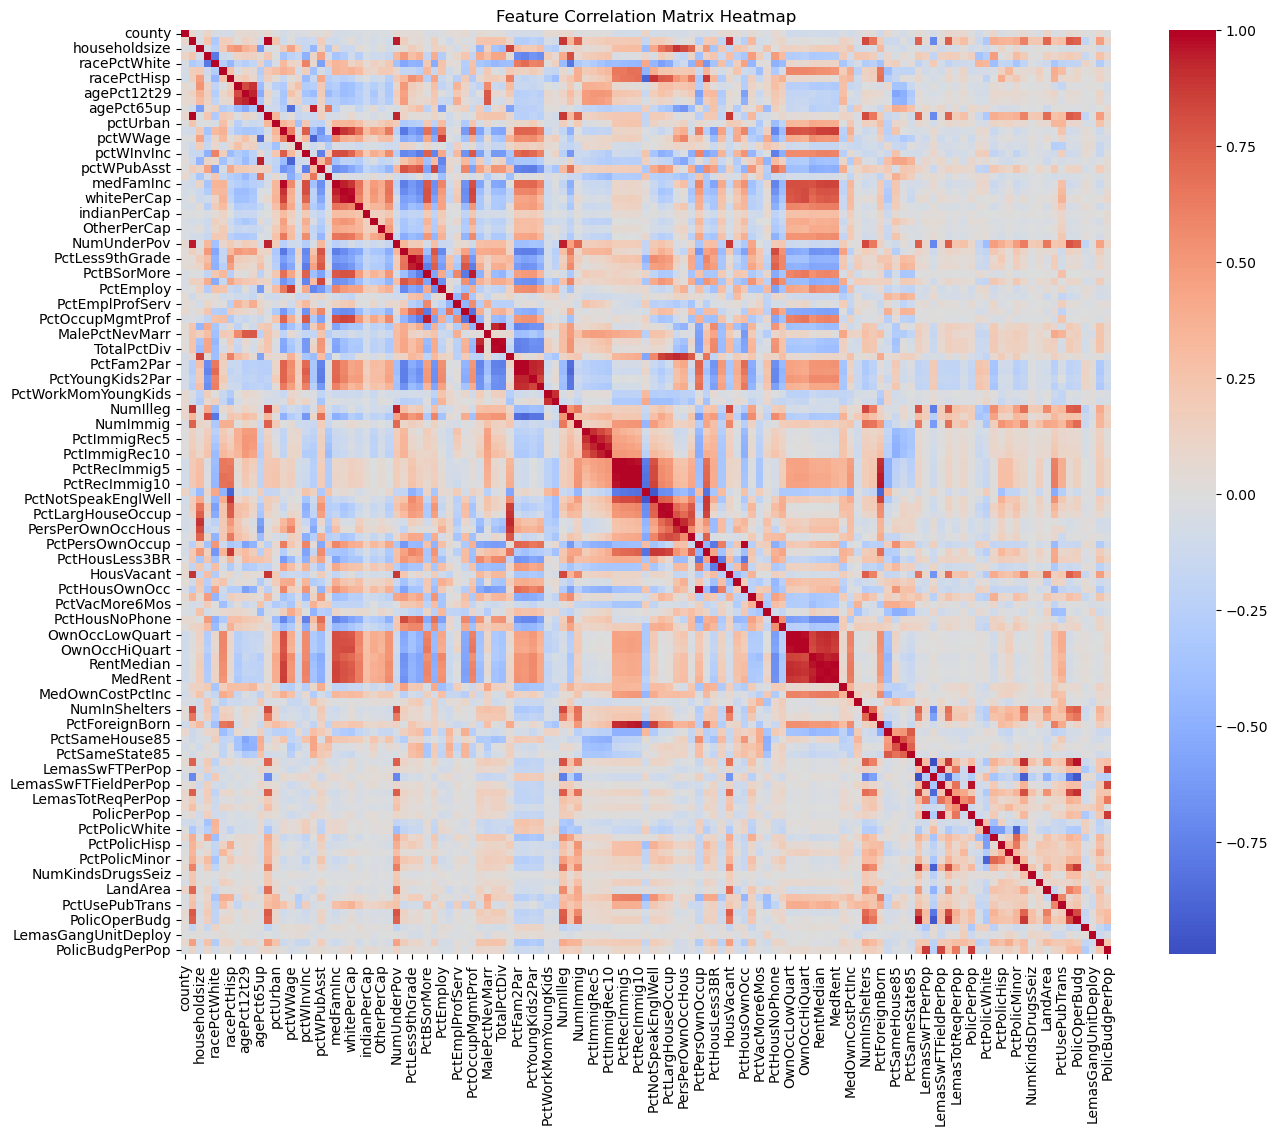

In [8]:
#plot a correlation matrix of only the features
#drop the target var
x = communities_data.drop(columns=['ViolentCrimesPerPop'])

cm = x.corr()
print(cm)

#plot heat map of correlation matrix
plt.figure(figsize=(15,12))
sns.heatmap(cm, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix Heatmap')
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [9]:
#Calculate the Coefficient of Variation CV for each feature, where CV = s/m
#in which s is sample standard deviation and m is sample mean.

#1)calculate mean and std
feature_means = x.mean()
feature_stds = x.std()

#calculate coefficient of variation
cv = feature_stds/feature_means

#display CV values
list_cv = cv.sort_values(ascending=False)
print(list_cv)


PctPolicAsian          5.447835
NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
                         ...   
NumKindsDrugsSeiz      0.143227
RacialMatchCommPol     0.126354
LemasPctPolicOnPatr    0.117979
PctPolicWhite          0.117372
LemasSwFTFieldOps      0.057515
Length: 123, dtype: float64


### (e) Scatter plots and box plots for highest CV features

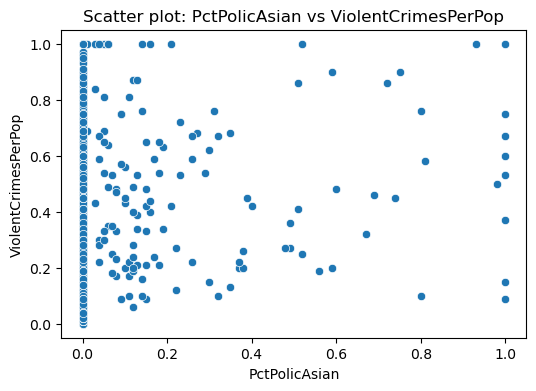

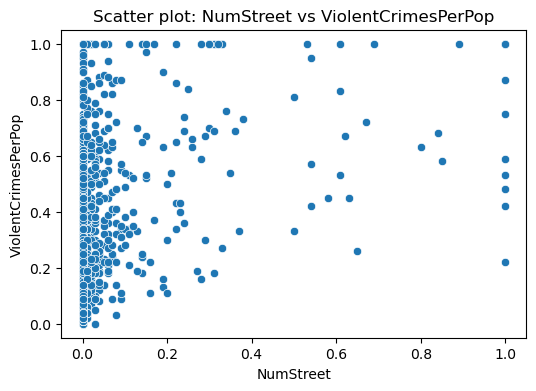

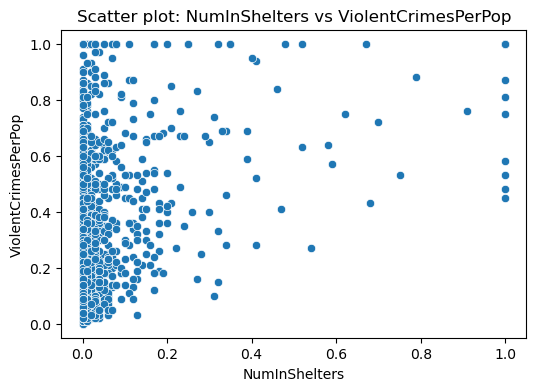

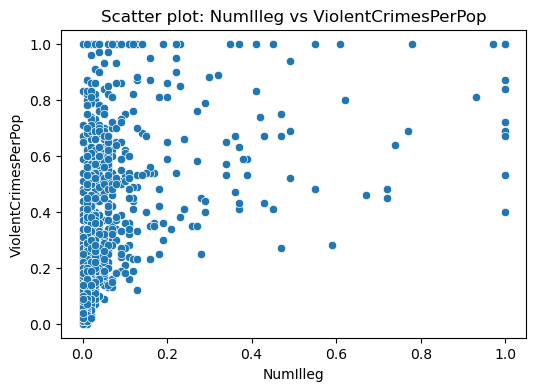

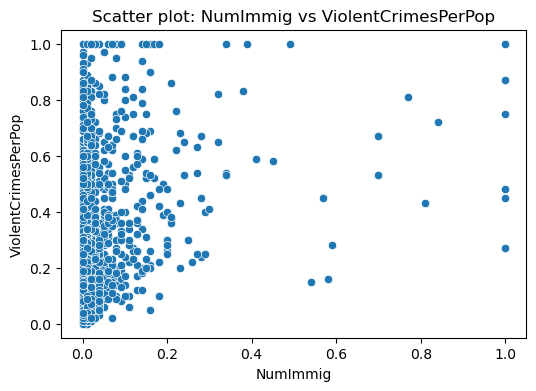

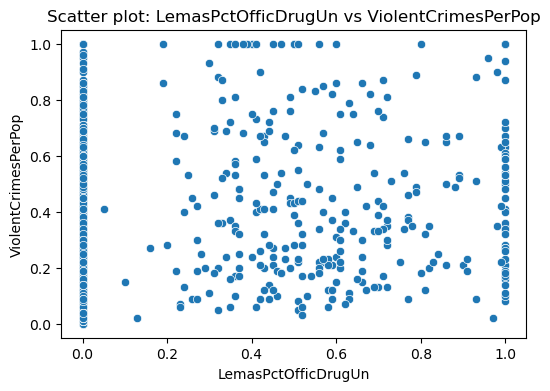

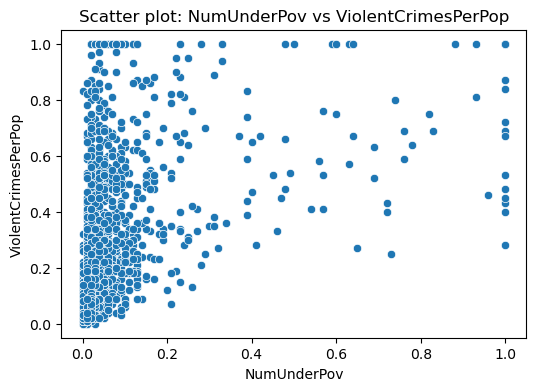

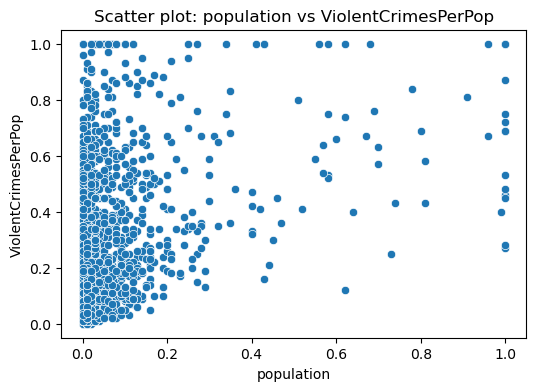

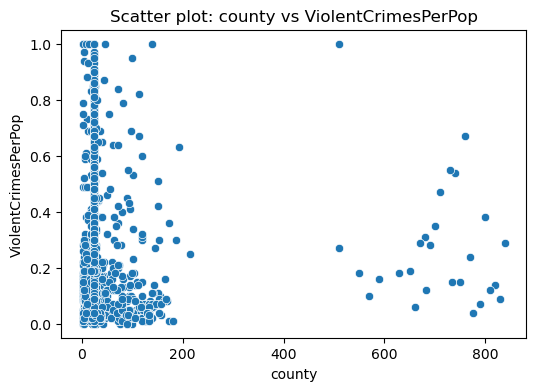

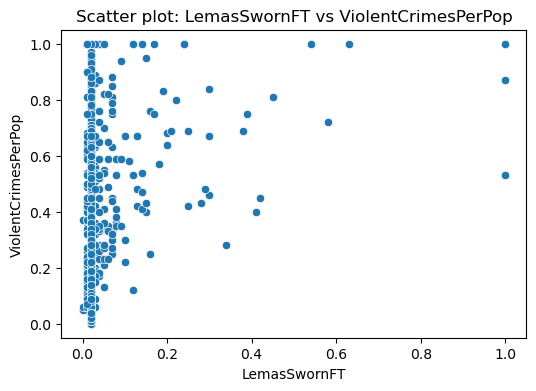

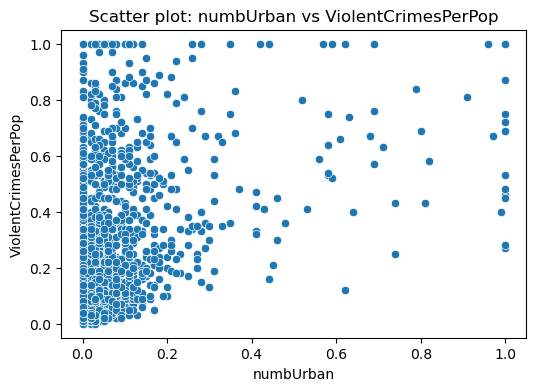

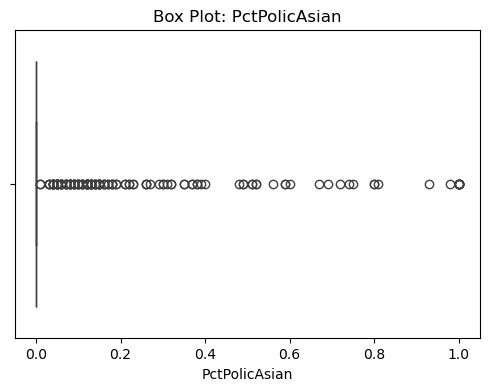

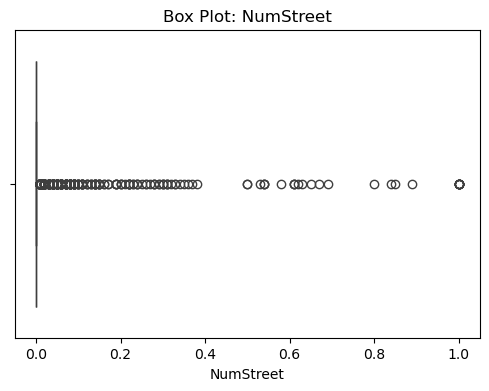

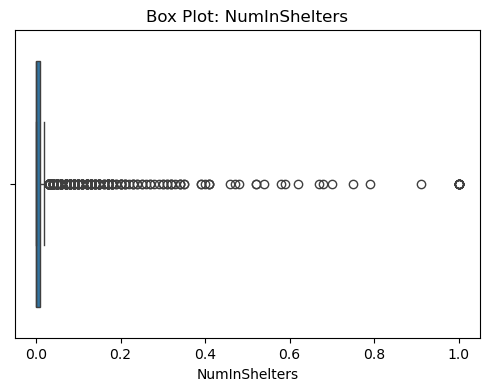

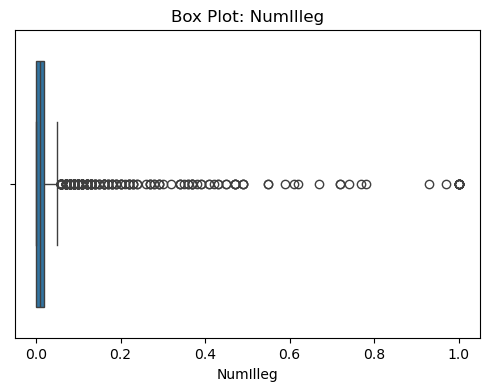

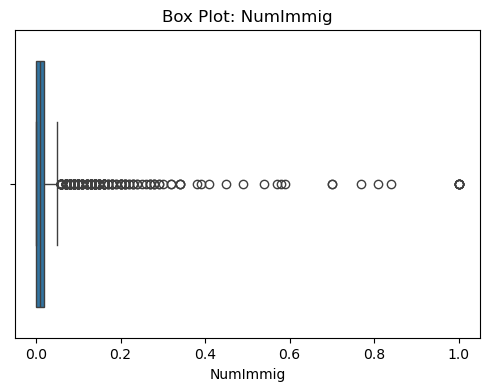

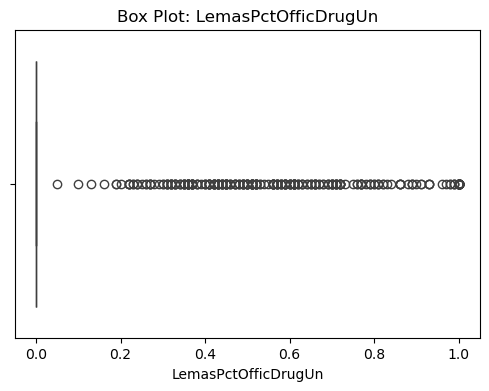

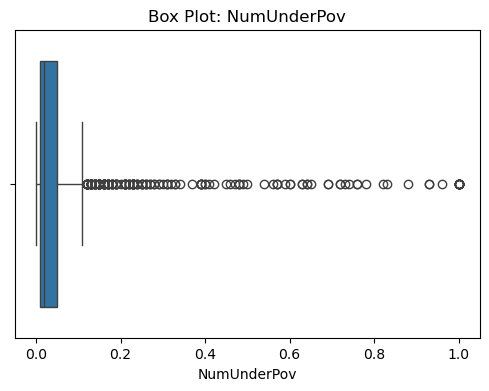

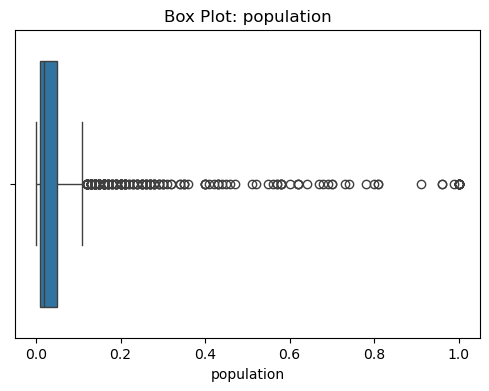

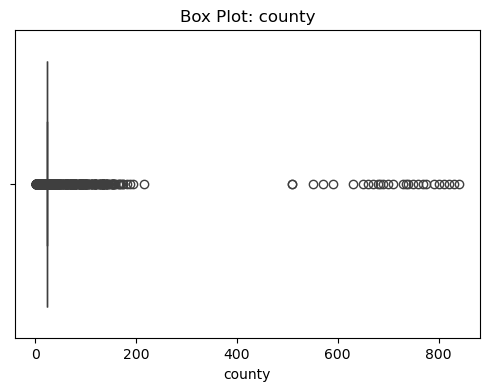

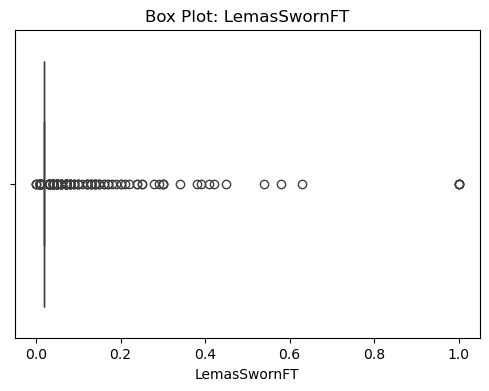

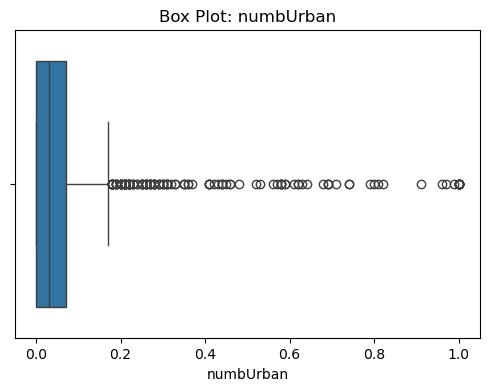

In [10]:
#Pick sqrt(128) features with highest CV , and make scatter plots and box plots for
#them. Can you draw conclusions about significance of those features, just by the
#scatter plots?

#sqrt(128) ~ 11
num_of_features = int(np.sqrt(128))

#get top features by highest cv
top_cv_features = list_cv.head(num_of_features).index.tolist()

#scatterplots
for feature in top_cv_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y='ViolentCrimesPerPop', data=communities_data)
    plt.title(f'Scatter plot: {feature} vs ViolentCrimesPerPop')
    plt.show()

#boxplots
for feature in top_cv_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=communities_data[feature])
    plt.title(f'Box Plot: {feature}')
    plt.show()

### (f) Fit a linear model

In [11]:
#linear model
#split into x and y again
x = communities_data.drop(columns='ViolentCrimesPerPop')
y = communities_data['ViolentCrimesPerPop']

#test/train split (90:10)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#fit linearreg model
lreg = LinearRegression()
lreg.fit(x_train, y_train)

#predict on test
y_lreg = lreg.predict(x_test)

#compute test error
test_mse = mean_squared_error(y_test, y_lreg)
print(f'Test MSE: {test_mse:.4f}')

Test MSE: 0.0180


### (g) Fit a ridge regression model

In [12]:
#find l based on cross validation
lambdas = np.logspace(-4, 4, 100)

ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=True)
ridge_cv.fit(x, y)

print(f"best lambda: {ridge_cv.alpha_: .6f}")

#fit ridge regression model with l=1.592283
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

ridge_model = RidgeCV(alphas=[ridge_cv.alpha_])
ridge_model.fit(x,y)
y_ridge = ridge_model.predict(x_test)

test_err = mean_squared_error(y_test, y_ridge)
print(f"Ridge Test Error: {test_err:.4f}")


C:\Users\anast\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


best lambda:  1.592283
Ridge Test Error: 0.0151


### (h) Fit a LASSO model

In [13]:
#test/train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#find best lambda
lambdas = np.logspace(-4, 1, 100)

#run cross validation to find best l
lasso_cv = LassoCV(alphas=lambdas, cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(x_train, y_train)
print(f"Best lambda: {lasso_cv.alpha_:.6f}")

#evaluate best l on test set
lasso_model = Lasso(alpha=lasso_cv.alpha_)
lasso_model.fit(x_train, y_train)

y_lasso = lasso_model.predict(x_test)

#compute test error
test_err_lasso = mean_squared_error(y_test, y_lasso)
print(f"Lasso test error: {test_err_lasso:.4f}")

#find the list of features selected by the model
coef_vars = pd.Series(lasso_model.coef_, index=x.columns)
selected_features = coef_vars[coef_vars != 0].sort_values(ascending=False)

print("Selected features:", selected_features)

# rerun Lasso with standardized features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

scaled_lambdas = np.logspace(-4, 1, 100)
lasso_cv_scaled = LassoCV(alphas=scaled_lambdas, cv=10, random_state=42, max_iter=10000)
lasso_cv_scaled.fit(x_train_scaled, y_train)

print(f"Best lambda after standardization: {lasso_cv_scaled.alpha_}")

#refit on scaled data using best l
lasso_model_scaled = Lasso(alpha=lasso_cv_scaled.alpha_)
lasso_model_scaled.fit(x_train_scaled, y_train)

y_scaled = lasso_model_scaled.predict(x_test_scaled)
test_err_scaled = mean_squared_error(y_test, y_scaled)

print(f"Test error for standardized lasso model: {test_err_scaled:.4f}")

#compare the test errors
if test_err_scaled < test_err_lasso:
    print('The standardized lasso model performs better, shown by the lower test error.')
elif test_err_scaled > test_err_lasso:
    print('The normal lasso model performs better, as it has a lower test error.')
else:
    print('Both models perform equally well.')

Best lambda: 0.000112
Lasso test error: 0.0163
Selected features: MedRent           0.181077
MalePctDivorce    0.168277
PctIlleg          0.162661
NumStreet         0.160141
HousVacant        0.156817
                    ...   
pctWInvInc       -0.157880
agePct12t29      -0.161997
PctPopUnderPov   -0.164279
RentLowQ         -0.179212
PctKids2Par      -0.252060
Length: 77, dtype: float64
Best lambda after standardization: 0.00045348785081285824
Test error for standardized lasso model: 0.0165
The normal lasso model performs better, as it has a lower test error.


### (i) Fit a PCR model

In [14]:
#start with range of principal components
m_components = np.arange(1, x.shape[1] + 1)

#store CV errors for each m
cv_errors = []
for m in m_components:
    #pcr model with m components
    pcr = PCA(n_components=m)
    x_train_pca = pcr.fit_transform(x)
    pcr_model = LinearRegression()

    #5-fold CV
    train_err = -np.mean(cross_val_score(pcr_model, x_train_pca, y, scoring='neg_mean_squared_error', cv=5))
    cv_errors.append(train_err)

#find best m (smallest CV error)
best_m = m_components[np.argmin(cv_errors)]
print(f"Best number of components (m): {best_m}")

#fit final PCR model using m=98
pcr_best_model = PCA(n_components=best_m)
x_train_pcr_final = pcr_best_model.fit_transform(x_train)
x_test_pcr_final = pcr_best_model.transform(x_test)

pcr_final = LinearRegression()
pcr_final.fit(x_train_pcr_final, y_train)

#find test error
y_pca = pcr_final.predict(x_test_pcr_final)
test_err_pca = np.mean((y_test - y_pca)**2)
print(f"PCA test error: {test_err_pca:.4f}")


Best number of components (m): 98
PCA test error: 0.0175


### (j) Fit a boosting tree

In [24]:
#In this section, we would like to fit a boosting tree to the data. As in classification
#trees, one can use any type of regression at each node to build a multivariate
#regression tree. Because the number of variables is large in this problem, one
#can use L1-penalized regression at each node. Such a tree is called L1 penalized
#gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine
#alpha (the regularization term) using cross-validation.

#L1reg parameter: find range of alphas to test
params_grid = {'reg_alpha': [0, 0.01, 0.1, 1, 10, 50, 100]}

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)
grid_cv = GridSearchCV(estimator=xgb, param_grid=params_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_cv.fit(x_train, y_train)

best_alpha = grid_cv.best_params_['reg_alpha']
print("Best alpha for l1 regularization via CV:", best_alpha)

#fit final model using best alpha
xgb_final_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_final_model.fit(x_train, y_train)

y_xgb = xgb_final_model.predict(x_test)
test_err_xgb = mean_squared_error(y_test, y_xgb)
print("XGB Test Error:", test_err_xgb)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best alpha for l1 regularization via CV: 0.1
XGB Test Error: 0.016858318913672184


#REFERENCES#

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://www.geeksforgeeks.org/machine-learning/building-and-implementing-decision-tree-classifiers-with-scikit-learn-a-comprehensive-guide/

https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

Copilot: find "optimal" dt based on highest interpretability

https://stats.stackexchange.com/questions/143700/which-is-better-replacement-by-mean-and-replacement-by-median

https://www.kaggle.com/code/pagenotfound/mean-and-median-imputation

https://seaborn.pydata.org/generated/seaborn.heatmap.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.variation.html

https://www.statology.org/coefficient-of-variation-in-python/

https://seaborn.pydata.org/generated/seaborn.boxplot.html

https://seaborn.pydata.org/generated/seaborn.scatterplot.html

https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

https://www.geeksforgeeks.org/machine-learning/ml-linear-regression/

https://www.geeksforgeeks.org/machine-learning/what-is-lasso-regression/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://stats.stackexchange.com/questions/82050/principal-component-analysis-and-regression-in-python

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://www.kaggle.com/code/kenji19840210/basic-prediction-with-xgboost-xgbregressor

copilot: how to use xgboost to fit a decision tree model